In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import warnings
import joblib
import os

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Download full historical data
ticker = "AAPL"
stock = yf.Ticker(ticker)
df = stock.history(period="max", interval="1d", auto_adjust=False).reset_index()
df['symbol'] = ticker

In [4]:
# Get dividend and split data
actions = stock.actions.reset_index()
dividends = actions[['Date', 'Dividends']].rename(columns={'Dividends': 'divCash'})
splits = actions[['Date', 'Stock Splits']].rename(columns={'Stock Splits': 'splitFactor'})

In [5]:
# Merge into main dataframe
df = df.merge(dividends, on='Date', how='left')
df = df.merge(splits, on='Date', how='left')
df['divCash'] = df['divCash'].fillna(0.0)
df['splitFactor'] = df['splitFactor'].fillna(1.0)

In [6]:
# Rename and reorder
df.rename(columns={
    'Date': 'date', 'Close': 'close', 'High': 'high', 'Low': 'low',
    'Open': 'open', 'Volume': 'volume', 'Adj Close': 'adjClose'
}, inplace=True)

In [7]:
df = df[['symbol', 'date', 'close', 'high', 'low', 'open', 'volume', 'adjClose', 'divCash', 'splitFactor']]
df.set_index('date', inplace=True)

# Clean up datetime index
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)

# Reindex to Business Days safely (fills missing with NaN)
df = df.asfreq('B')

# Save cleaned version
df.to_csv(f"{ticker}_historical_data.csv")



In [8]:
# Prepare for ARIMA
arima_df = df
arima_df = arima_df.fillna(method='ffill').fillna(method='bfill')
ts1 = arima_df['close']
ts1.index = pd.to_datetime(ts1.index)
ts1.sort_index(inplace=True)

In [9]:
arima_df.head()

,symbol,close,high,low,open,volume,adjClose,divCash,splitFactor
date,,,,,,,,,
1980-12-12,AAPL,0.128348,0.128906,0.128348,0.128348,469033600.0,0.098597,0.0,1.0
1980-12-15,AAPL,0.121652,0.122210,0.121652,0.122210,175884800.0,0.093453,0.0,1.0
1980-12-16,AAPL,0.112723,0.113281,0.112723,0.113281,105728000.0,0.086594,0.0,1.0
1980-12-17,AAPL,0.115513,0.116071,0.115513,0.115513,86441600.0,0.088737,0.0,1.0
1980-12-18,AAPL,0.118862,0.119420,0.118862,0.118862,73449600.0,0.091310,0.0,1.0


In [10]:
arima_df.shape

(11638, 9)

In [11]:
# Ensure datetime index and proper frequency
ts1.index = pd.to_datetime(ts1.index)
ts1 = ts1.asfreq('B')  # Reindex to business (weekdays)

# Now fill missing values
ts1 = ts1.interpolate(method='time')

In [12]:
# Train ARIMA model on entire series
stepwise_model = auto_arima(ts1, start_p=1, start_q=1,
                            max_p=5, max_q=5, d=None,
                            seasonal=False, trace=False,
                            error_action='ignore',
                            suppress_warnings=True, stepwise=True)

In [13]:
# Forecast next 30 business days
n_periods = 30
forecast, conf_int = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)
future_dates = pd.date_range(start=ts1.index[-1], periods=n_periods + 1, freq='B')[1:]

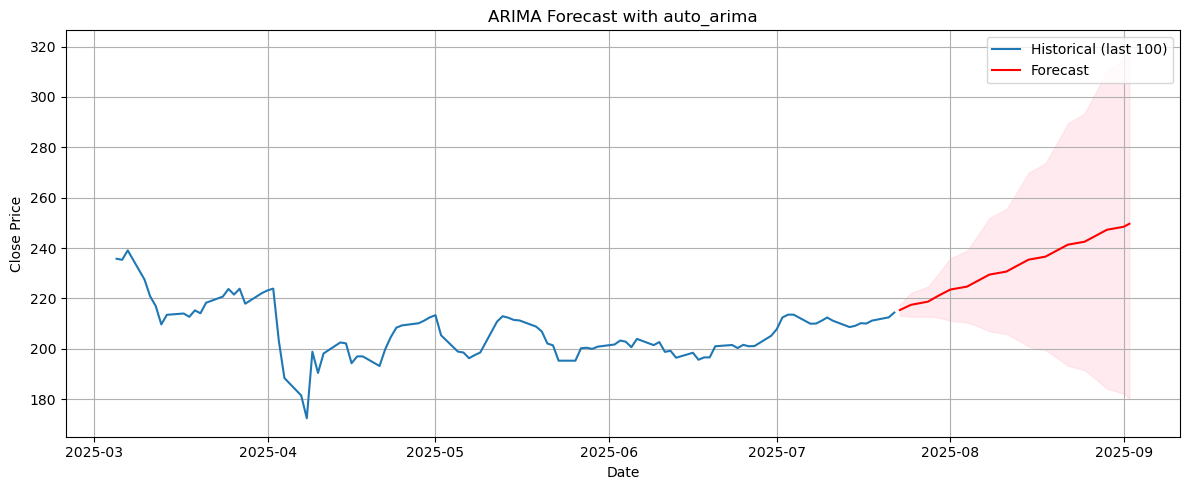

In [14]:
# Plot full forecast
plt.figure(figsize=(12, 5))
plt.plot(ts1[-100:], label='Historical (last 100)')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast with auto_arima')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Evaluation on test set (last 30)
train = ts1[:-30]
test = ts1[-30:]

In [16]:
stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, d=None,
                            seasonal=False, trace=False,
                            error_action='ignore',
                            suppress_warnings=True, stepwise=True)

forecast, conf_int = stepwise_model.predict(n_periods=len(test), return_conf_int=True)

In [17]:
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"ARIMA Model Evaluation (on test set):")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

ARIMA Model Evaluation (on test set):
MAE  = 5.3888
RMSE = 5.8921
MAPE = 2.60%


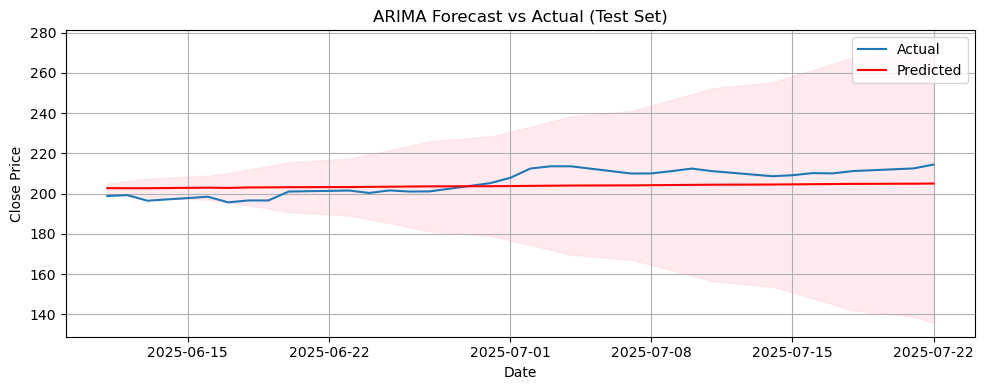

In [18]:
# Plot test forecast
plt.figure(figsize=(10, 4))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Predicted", color="red")
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title("ARIMA Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Save model (ensure directory exists)
os.makedirs("models", exist_ok=True)
joblib.dump(stepwise_model, "models/arima_model.pkl")
print("✅ ARIMA model saved successfully at models/arima_model.pkl")

✅ ARIMA model saved successfully at models/arima_model.pkl


In [20]:
arima_df.head()

,symbol,close,high,low,open,volume,adjClose,divCash,splitFactor
date,,,,,,,,,
1980-12-12,AAPL,0.128348,0.128906,0.128348,0.128348,469033600.0,0.098597,0.0,1.0
1980-12-15,AAPL,0.121652,0.122210,0.121652,0.122210,175884800.0,0.093453,0.0,1.0
1980-12-16,AAPL,0.112723,0.113281,0.112723,0.113281,105728000.0,0.086594,0.0,1.0
1980-12-17,AAPL,0.115513,0.116071,0.115513,0.115513,86441600.0,0.088737,0.0,1.0
1980-12-18,AAPL,0.118862,0.119420,0.118862,0.118862,73449600.0,0.091310,0.0,1.0
